# Importing required package

In [1]:
import os
import re
import time 
import random
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data
    - using only 5 categories
        - alt.atheism
        - talk.religion.misc
        - talk.politics.misc
        - comp.graphics
        - sci.space

In [2]:
# list of categories for training model
categories = ['alt.atheism', 'talk.religion.misc', 'talk.politics.misc', 'comp.graphics', 'sci.space']
news_group_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, remove=['headers', 'footers', 'quotes'], random_state=42)
# display
print("Data target_name:\n", news_group_data.target_names)
print("Data: ", len(news_group_data['data']))

Data target_name:
 ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.misc', 'talk.religion.misc']
Data:  4162


In [3]:
# calculate frequency
target, count_target = np.unique(news_group_data.target, return_counts=True)
target_names = np.array(news_group_data.target_names)
print(list(zip(target_names, count_target)))

[('alt.atheism', 799), ('comp.graphics', 973), ('sci.space', 987), ('talk.politics.misc', 775), ('talk.religion.misc', 628)]


# Converting into pandas dataframe

In [4]:
complete_df = pd.DataFrame({'data':news_group_data.data, 'target':news_group_data.target})
complete_df.head()

,data,target
0,\nPeter Nelson posted a very eloquent response...,3
1,\nNo.\n\n\nNo. The library at Alexandria was p...,4
2,\nWouldn't this require a hyper-sphere. In 3-...,1
3,Forwarded from:\nPUBLIC INFORMATION OFFICE\nJE...,2
4,can someone tell me where i could find ansi or...,1


In [5]:
# size of data
print(len(complete_df))

4162


# Data Processing
- WordNetLemmatizer() - removing all the special characters, spaces, character from start, and also converting into lower case
- removing stopwords

In [6]:
# creating corpus list for iterating over text feature from data
corpus = list() 
# iterating over text data
for texts in range(0, len(complete_df)):
    # remove special character
    input_text = re.sub(r'\W', ' ', complete_df['data'][texts])
    # remove single character
    input_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', input_text)
    # removing single character from start
    input_text = re.sub(r'\^[a-zA-Z]\s+', ' ', input_text)
    # multiple spaces into single spaces
    input_text = re.sub(r'\s+', ' ', input_text, flags=re.I)
    # removing prefixes
    input_text = re.sub(r'^b\s+', '', input_text)
    # into lower case
    input_text = input_text.lower()
    input_text = input_text.split()
    # initialise the WordNetLemmatizer()
    stemmer = WordNetLemmatizer()
    input_text = [stemmer.lemmatize(word) for word in input_text if not word in set(stopwords.words('english'))]
    input_text = ' '.join(input_text)
    # append list
    corpus.append(input_text)

# sanity check
print(corpus[:2])

['peter nelson posted eloquent response point talk politics misc need consume bandwidth meant clear intersection set liberal libertarian philosophy natural right government constitutional interpretation particular fit philosophy philosophy engages serious practical error endowing nine lawyer supreme court almost totalitarian authority completely outside consent consensus people supreme court nomination amazing political fist fight day control court rule country people court may well trying best job best benevolent oligarch even approve every supreme court decision ever eventually oligarch arise decimate hold dear try supreme court case jury problem would mitigated great deal would create broad non enumerated government power level european parlamentary democracy current de facto standard essentially engaged fundamental mistake except different body totalitarian virtually unchecked except plurality election death retirement government power like asking wind blow unless prove fact engagi

# Bag of Words Model
- TF-IDF (Term Frequency - Inverse Document frequency) - Convert a collection of raw documents to a matrix of TF-IDF features 
- CountVectoirzer - Convert a Collection of text documents to a matrix of token counts

Note: Choosing CountVectorizer() for this project



In [7]:
# define tokenizer function
def tokenizer(text):
    """
    Function to split the sentence into individual words.
    Args:
    Sentence: document containing Sentence (str)
    Returns:
    List of split individual words (Token)
    """
    return word_tokenize(text)

# sanity check
sentence = "Hi there, how have you been!?"
tokenizer(sentence)

['Hi', 'there', ',', 'how', 'have', 'you', 'been', '!', '?']

In [8]:
# # creating TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenizer, max_features=10000, use_idf=True)
# X = tfidf_vectorizer.fit_transform(corpus).toarray() # corpus is complete_df['data']
# y = complete_df.iloc[:, -1].values # labbels as target feature
# print(len(X[0])) #

In [9]:
# Creating the Bag of Words model
count_vetorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenizer, max_features=10000)
X = count_vetorizer.fit_transform(corpus).toarray() # corpus is complete_df['data']
y = complete_df.iloc[:, -1].values # labbels as target feature
print(len(X[0]))
print("Input feature's Shape: ", X.shape)

10000
Input feature's Shape:  (4162, 10000)


# Splitting the dataset into the Training and Test set
- 80:20

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (3329, 10000)
x_test:  (833, 10000)
y_train:  (3329,)
y_test:  (833,)


In [11]:
print(x_train[:1])

[[1 0 0 ... 0 0 0]]


# Define model
- Naive Bayes - MultinomialNB()
- SVM - Linear SVC
- Neural Network - MLPClassifier()
- comparing with Ensemble - Votting Classifier (hard votting)

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
# define function - model_ensembler()
def model_ensembler():
    # model list
    models = list()
    # define models - SVM, Naive Bayes, NN
    models.append(('SVM', SVC(gamma='auto', kernel='linear')))
    models.append(('Naive Bayes', MultinomialNB()))
    # pipeline using MinMaxScaler(), as the MLPClassifier accpet the data to be scaled
    models.append(('NN', make_pipeline(MinMaxScaler(), MLPClassifier(early_stopping=True, max_iter=10000, hidden_layer_sizes=[100, 100], solver='lbfgs', random_state=32))))
    # define votting classifier
    hard_voting_ensemble = VotingClassifier(estimators=models, voting='hard') # with largest sum of votes from models
    hard_voting_ensemble = hard_voting_ensemble.fit(x_train, y_train)
    
    return hard_voting_ensemble

In [15]:
def evaluate_models():
    # empty dict
    models = dict()
    # define model for evaluation
    models['SVM'] = SVC(gamma='auto', kernel='linear')
    models['Naive Bayes'] = MultinomialNB()
    models['NN'] = make_pipeline(MinMaxScaler(), MLPClassifier(early_stopping=True, max_iter=10000, hidden_layer_sizes=[100, 100], solver='lbfgs', random_state=32))
    models['Hard Voting Ensembler'] = model_ensembler()
    return models

# evaluation using Cross-validation - RepeatedStratifiedKFold()
def cross_validation_evaluation(model, x_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=5, random_state=1, n_repeats=3)
    scores=cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy', error_score='raise')
    return scores

# get the models evaluation
models = evaluate_models()
# empty lists
results, model_names = list(), list()
for name, model in models.items():
    scores = cross_validation_evaluation(model, x_train, y_train)
    results.append(scores)
    model_names.append(name)
    print('>>>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>>>SVM 0.669 (0.014)
>>>Naive Bayes 0.780 (0.010)
>>>NN 0.707 (0.018)
>>>Hard Voting Ensembler 0.765 (0.011)


# Model comparison
- Boxplot

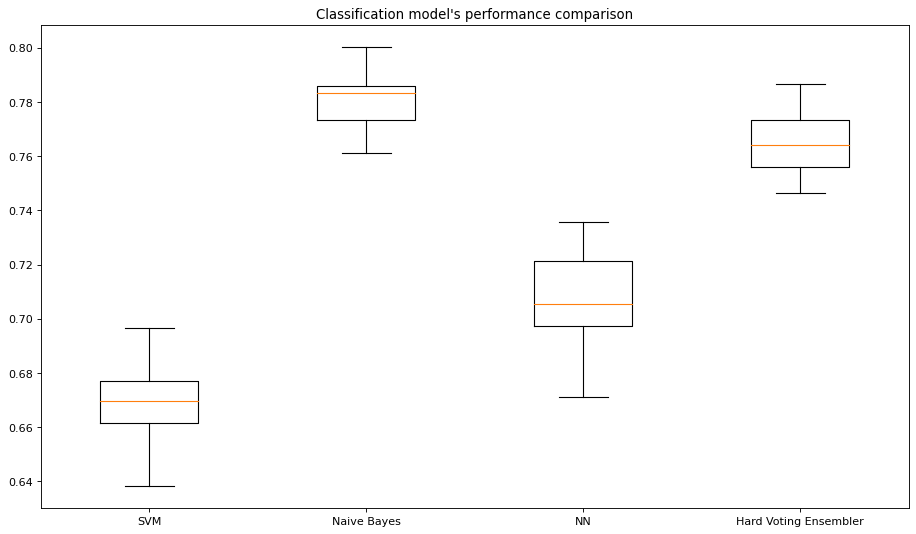

In [16]:
figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(results, labels=model_names)
plt.title("Classification model's performance comparison")
plt.show()

# Chossing best model
    - Naive Bayes is the nest performing model

In [17]:
# function - SVM
def nb_classifier():
    model = MultinomialNB().fit(x_train, y_train)
    return model

# calling function
classifier = nb_classifier()
print(classifier)

# predictions
y_pred = classifier.predict(x_test)
print(y_pred[:20])

MultinomialNB()
[2 2 1 4 2 4 2 3 0 0 0 4 0 1 3 2 3 2 0 0]


# Evaluation metrics
    - Confusion matrix
    - Classfication matrix

In [19]:
# Confusion Matrix
print("================ Confusion Matrix ================")
print(confusion_matrix(y_test, y_pred))

print() # blank line

# Classification report
print("============= Classification Report ==============") 
print(classification_report(y_test, y_pred))

================ Confusion Matrix ================
[[118   1   3  13  23]
 [  4 171  19   2   2]
 [  8   8 169   5   2]
 [ 15   2  10 140   4]
 [ 33   2  10  11  58]]

============= Classification Report ==============
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       158
           1       0.93      0.86      0.90       198
           2       0.80      0.88      0.84       192
           3       0.82      0.82      0.82       171
           4       0.65      0.51      0.57       114

    accuracy                           0.79       833
   macro avg       0.77      0.76      0.77       833
weighted avg       0.79      0.79      0.79       833

